In [ ]:
import torch
import torch.nn as nn

import pandas as pd
import os
import json
from tempdisagg import TempDisaggModel

In [45]:
from disaggregation import main
subset = main() 
subset.head()

Disaggregated CSV exists. Loading...


,Unnamed: 3,Inflation,Population,GDP,Imports,Exports,Agriculture,Industry,Services,USDPHP,Nominal GDP,TotalTrade,TotalTrade_PHPMN,NominalGDP_disagg,Population_Disagg
0,1991-01-01,18.7,NaN,NaN,950.41,635.57,NaN,NaN,NaN,28.0000,NaN,1585.98,44407.440000,78331.432383,6.253445e+07
1,1991-02-01,20.2,NaN,NaN,1094.81,662.65,NaN,NaN,NaN,28.0000,NaN,1757.46,49208.880000,116416.848895,6.254789e+07
2,1991-03-01,21.1,NaN,1243019.24,1076.87,742.13,18.29,31.98,49.73,28.0000,325283.0,1819.00,50932.000000,130534.718722,6.257476e+07
3,1991-04-01,20.6,NaN,NaN,896.52,709.70,NaN,NaN,NaN,27.9261,NaN,1606.22,44855.460342,118582.808747,6.261507e+07
4,1991-05-01,20.8,NaN,NaN,983.15,688.51,NaN,NaN,NaN,27.8186,NaN,1671.66,46503.240876,112959.255665,6.266881e+07


## Data Preprocessing

In [33]:
from statsmodels.tsa.stattools import coint
data = pd.read_csv('Data/Macro.csv')
data['Exports_numeric'] = pd.to_numeric(data['Exports'], errors='coerce')
data['Imports_numeric'] = pd.to_numeric(data['Imports'], errors='coerce')
data['USDPHP_numeric'] = pd.to_numeric(data['USDPHP'], errors='coerce')

data['Monthly_Trade_PHP'] = (
    data['Exports_numeric'] + data['Imports_numeric']
) * data['USDPHP_numeric']

# Create quarterly trade by summing 3 months
data['Date'] = pd.to_datetime(data['Year'].astype(str) + '-' + 
                             data['Month'].astype(str) + '-01')
data.set_index('Date', inplace=True)

# Resample to quarterly sum
quarterly_trade = data['Monthly_Trade_PHP'].resample('QE').sum()

# Get quarterly GDP (remove NaNs)
quarterly_gdp = data['Nominal GDP'].resample('QE').mean().dropna()

# Align both series on common dates
start, end = "1991-01-01", "2004-12-31"

gdp_series = quarterly_gdp.loc[start:end]
trade_series = quarterly_trade.loc[start:end]

# Test for cointegration
coint(gdp_series, trade_series, autolag='AIC')


(np.float64(-2.3757208699955488),
 np.float64(0.3364386725432962),
 array([-4.10664876, -3.44947826, -3.1224619 ]))

In [ ]:
data = pd.read_csv('Data/Macro.csv')
col = data.columns[3]
data[col] = pd.to_datetime(data[col], dayfirst=True)
subset = data[(data[col] >= "1991-01-01") & (data[col] <= "2024-12-31")].copy()


Temporal Disaggregation Model Summary

Method: litterman-opt
Estimated rho: 0.9900
      Coef.    Std.Err.            t-stat       P>|t| Signif.       Score
0.445547971 0.000000099 4486481.191089949 0.000000000     *** 0.000000172


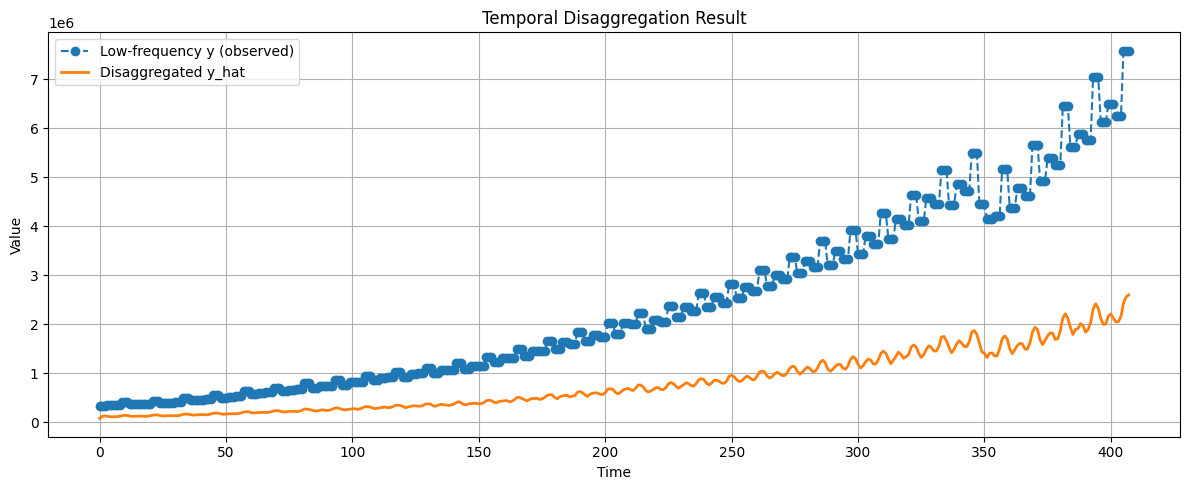

In [ ]:
##nominal gdp
df = pd.DataFrame({'Index': subset['Year']})
df['Index'] = df['Index'].astype(int) * 10 + ((df.index // 3) % 4 + 1)
df['Grain'] = (list(range(1, 4)) * len(df))[:len(df)]

df['y'] = data['Nominal GDP']
df['y'] = df.groupby('Index')['y'].bfill()
df['X'] = (
    pd.to_numeric(data['Exports'], errors='coerce') +
    pd.to_numeric(data['Imports'], errors='coerce')
) * pd.to_numeric(data['USDPHP'], errors='coerce')

model = TempDisaggModel(method="litterman-opt", conversion="sum")
model.fit(df)

y_hat = model.predict(full=False)
y_adj = model.adjust_output(full=False)

# Summary and plot
model.summary()
model.plot()


Temporal Disaggregation Model Summary

Method: denton
             Coef.    Std.Err.               t-stat       P>|t| Signif.       Score
62534454.865292937 0.049507377 1263134071.459613085 0.000000000     *** 0.000000527


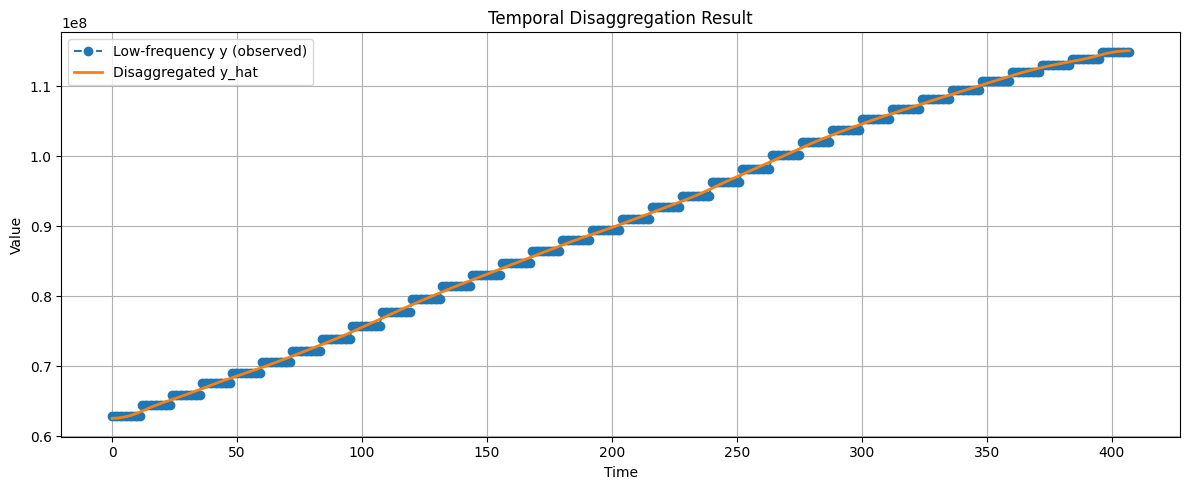

In [44]:
df = pd.DataFrame({'Index': subset['Year']})
df['Index'] = df['Index'].astype(int)  # yearly
df['Grain'] = (list(range(1, 13)) * len(df))[:len(df)]  # monthly

df['y'] = data['Population']
df['y'] = df.groupby('Index')['y'].bfill()  # backfill within year
df['X'] = 1.0

df = df.reset_index(drop=True)
model = TempDisaggModel(method="denton", conversion="average")
model.fit(df)

y_hat = model.predict(full=False)
y_adj = model.adjust_output(full=False)

# Summary and plot
model.summary()
model.plot()

## Model Building